In [1]:
from sklearnex import patch_sklearn 

patch_sklearn()

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import module as mod

from sklearn.preprocessing import MinMaxScaler, StandardScaler

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


# 1. Exploration des données

Le jeu de données est disponible à cette adresse : https://archive.ics.uci.edu/ml/datasets/individual+household+electric+power+consumption

**Data Set Information:**

This archive contains 2075259 measurements gathered in a house located in Sceaux (7km of Paris, France) between December 2006 and November 2010 (47 months).
Notes:
1. (global_active_power*1000/60 - sub_metering_1 - sub_metering_2 - sub_metering_3) represents the active energy consumed every minute (in watt hour) in the household by electrical equipment not measured in sub-meterings 1, 2 and 3.
2. The dataset contains some missing values in the measurements (nearly 1,25% of the rows). All calendar timestamps are present in the dataset but for some timestamps, the measurement values are missing: a missing value is represented by the absence of value between two consecutive semi-colon attribute separators. For instance, the dataset shows missing values on April 28, 2007.

**Attribute Information:**

1. date: Date in format dd/mm/yyyy
2. time: time in format hh:mm:ss
3. global_active_power: household global minute-averaged active power (in kilowatt)
4. global_reactive_power: household global minute-averaged reactive power (in kilowatt)
5. voltage: minute-averaged voltage (in volt)
6. global_intensity: household global minute-averaged current intensity (in ampere)
7. sub_metering_1: energy sub-metering No. 1 (in watt-hour of active energy). It corresponds to the kitchen, containing mainly a dishwasher, an oven and a microwave (hot plates are not electric but gas powered).
8. sub_metering_2: energy sub-metering No. 2 (in watt-hour of active energy). It corresponds to the laundry room, containing a washing-machine, a tumble-drier, a refrigerator and a light.
9. sub_metering_3: energy sub-metering No. 3 (in watt-hour of active energy). It corresponds to an electric water-heater and an air-conditioner.

In [2]:
data = pd.read_csv('data/household_power_consumption.zip', index_col='datetime')

# we change the index into the proper format
data.index = pd.to_datetime(data.index)
data = data.asfreq('1min')

# we drop the columns that don't interest us
data = data.drop(columns=['Global_reactive_power', 'Voltage', 'Global_intensity'])

# we remove the 25979 na values
data = data.interpolate(method='linear')

# we convert the kWh to W and the kW to W
data[['Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3']] = data[['Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3']]/60*1000
data['Global_active_power'] = data['Global_active_power']*1000
data['Other'] = data['Global_active_power'] - data[['Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3']].sum(axis=1)

# we rename the columns
data = data.rename(columns={'Global_active_power': 'mains', 'Sub_metering_1': 'Kitchen', 'Sub_metering_2': 'Laundry Room', 'Sub_metering_3': 'Heater and A/C'})

data.head()

,mains,Kitchen,Laundry Room,Heater and A/C,Other
datetime,,,,,
2006-12-16 17:24:00,4216.0,0.0,16.666667,283.333333,3916.000000
2006-12-16 17:25:00,5360.0,0.0,16.666667,266.666667,5076.666667
2006-12-16 17:26:00,5374.0,0.0,33.333333,283.333333,5057.333333
2006-12-16 17:27:00,5388.0,0.0,16.666667,283.333333,5088.000000
2006-12-16 17:28:00,3666.0,0.0,16.666667,283.333333,3366.000000


In [87]:
data.shape

(2075259, 5)

Y-a-t-il des données dupliquées ?

In [88]:
data.index.duplicated().any()

False

Sur quelle durée s'étend les mesures ?

In [69]:
print(f'Data from {data.index[0]} to {data.index[-1]}')

Data from 2006-12-16 17:24:00 to 2010-11-26 21:02:00


Affichons la première journée de relevés

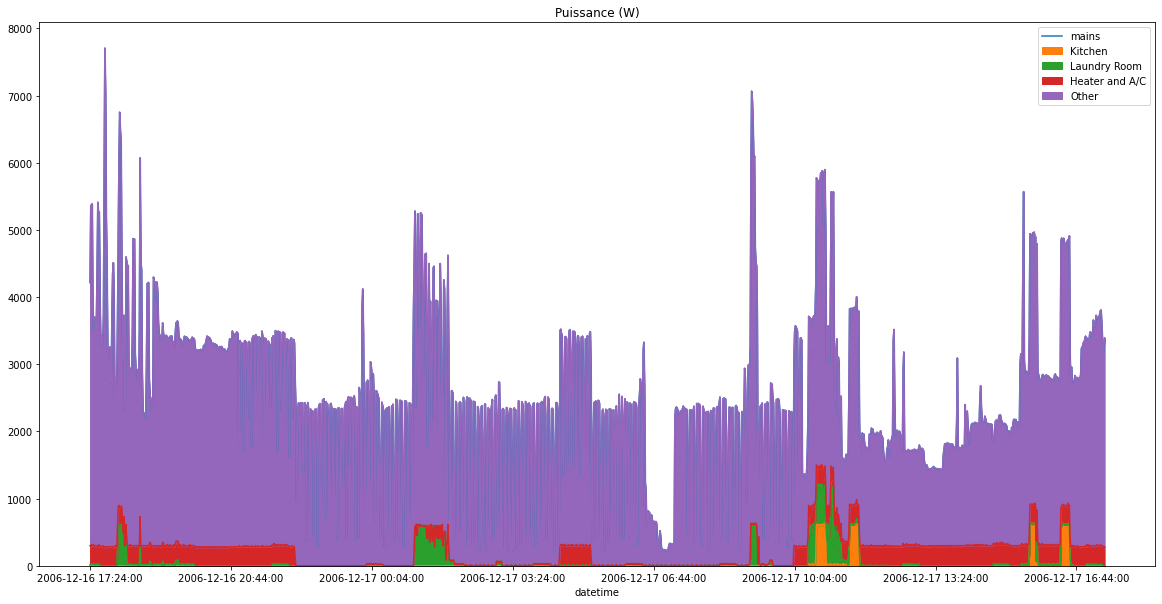

In [89]:
ax = data.loc['2006-12-16 17:24:00':'2006-12-17 17:24:00', 'mains'].plot(figsize=(20,10), title='Puissance (W)', legend='mains');
data.loc['2006-12-16 17:24:00':'2006-12-17 17:24:00', ['Kitchen', 'Laundry Room', 'Heater and A/C', 'Other']].plot.area(ax=ax);

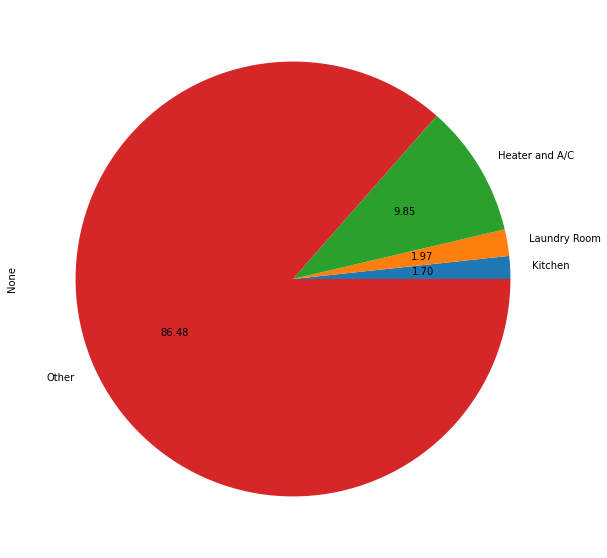

In [90]:
data[['Kitchen', 'Laundry Room', 'Heater and A/C', 'Other']].mean().plot(kind='pie', autopct='%.2f', figsize=(10,10));

Un grand problème avec ce jeu de données est lié au fait que la majorité de la puissance consommée provient de sources inconnues.

# 2. Classification

On peut essayer d'ajouter des labels à partir d'un classifieur entrainé sur les jeux de données initiaux.

In [3]:
# we load house 1
house1_power_blk2 = mod.load_dataset('data/house1_power_blk2_labels.zip')

# we load house 2
house2_power_blk1 = mod.load_dataset('data/house2_power_blk1_labels.zip')

# we combine both houses
dataset1 = house1_power_blk2.append(house2_power_blk1)
dataset1.head()

,mains,activity,hour
datetime,,,
2016-03-06 00:00:00,473.0,0,0
2016-03-06 00:00:01,474.0,0,0
2016-03-06 00:00:02,476.0,0,0
2016-03-06 00:00:03,476.0,0,0
2016-03-06 00:00:04,475.0,0,0


In [4]:
dataset1, features_col, _ = mod.generate_scaled_features(dataset1)
dataset1.head()

,mains,activity,hour,mains_scaled,mean_1h_scaled,std_1h_scaled,maxmin_1h_scaled,hour_scaled
datetime,,,,,,,,
2016-03-06 00:00:00,473.0,0,0,-0.308148,-0.400848,-0.747822,-0.749440,-1.661325
2016-03-06 00:00:01,474.0,0,0,-0.306976,-0.400086,-0.747822,-0.747152,-1.661325
2016-03-06 00:00:02,476.0,0,0,-0.304633,-0.398816,-0.745944,-0.742575,-1.661325
2016-03-06 00:00:03,476.0,0,0,-0.304633,-0.398181,-0.746007,-0.742575,-1.661325
2016-03-06 00:00:04,475.0,0,0,-0.305804,-0.398105,-0.746456,-0.742575,-1.661325


In [5]:
# train data set = house 1
X_train = dataset1[features_col].values
y_train = dataset1['activity'].values

In [6]:
data['hour'] = data.index.hour
data, _, _ = mod.generate_scaled_features(data)

In [7]:
X_test = data[features_col].values

In [8]:
from sklearn.ensemble import RandomForestClassifier

# we create and train our model
rfc = RandomForestClassifier(n_estimators=30, n_jobs=-1, max_samples=0.8, max_depth=10)
rfc.fit(X_train, y_train.ravel())

# we make predictions
data['activity'] = rfc.predict(X_test)

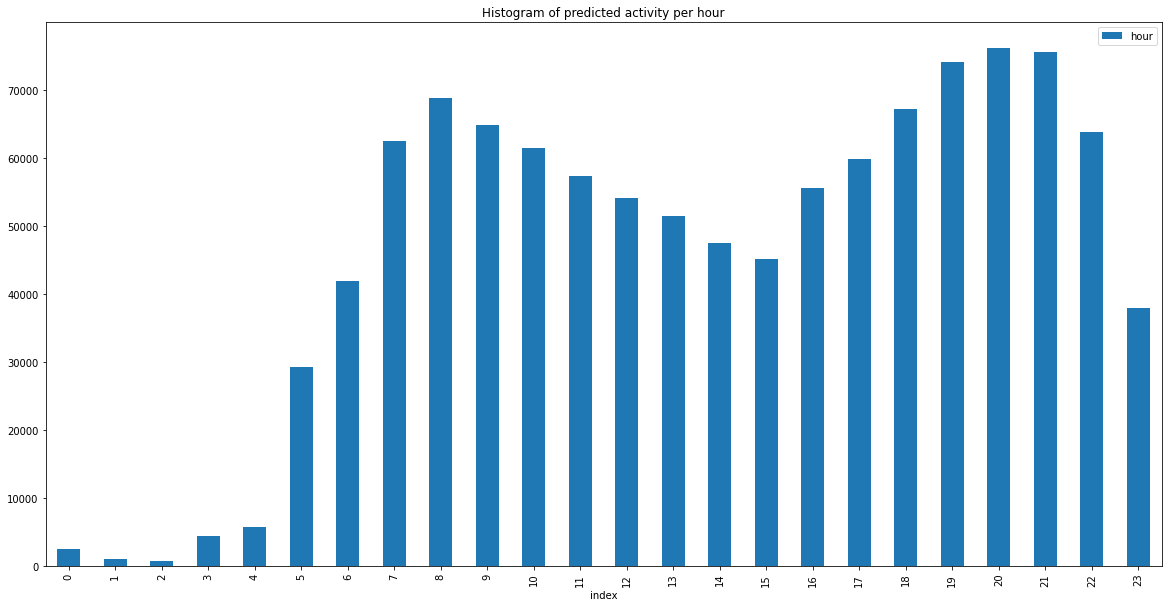

In [9]:
pd.DataFrame(data.loc[data['activity'] > 0, 'hour'].value_counts()).reset_index(drop=False).sort_values(by='index').plot.bar(x='index', y='hour', figsize=(20,10), legend='Histogramme activité=f(heure)', title='Histogram of predicted activity per hour');

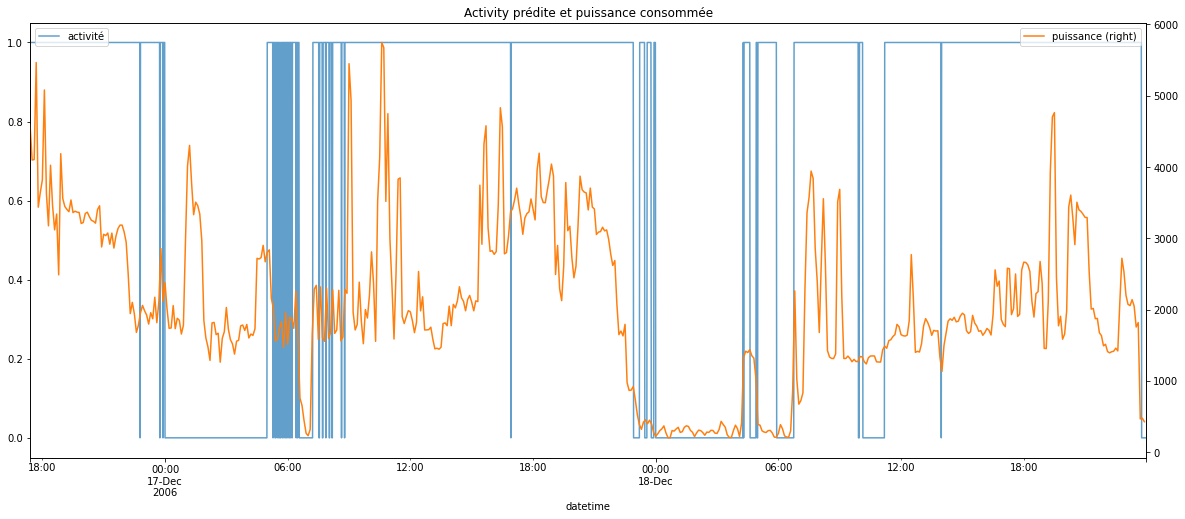

In [12]:
display_window = ['2006-12-16 17:24:00', '2006-12-18 23:59:59']

ax = data.loc[display_window[0]:display_window[-1], 'activity'].plot(title='Activity prédite et puissance consommée', label='activité', alpha=0.7, figsize=(20,8));
axr = data.loc[display_window[0]:display_window[-1], 'mains'].resample(rule='0.1H').mean().plot(secondary_y=True, label='puissance', ax=ax);

ax.legend(loc='upper left');
axr.legend(loc='upper right');